In [1]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

! conda install -c rdkit rdkit -y

--2021-12-22 02:02:13--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   266MB/s    in 0.3s    

2021-12-22 02:02:13 (266 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h

In [2]:
! pip install molvs

     |████████████████████████████████| 61 kB 478 kB/s 
  Created wheel for molvs: filename=MolVS-0.1.1-py3-none-any.whl size=32376 sha256=9476a4de27a6ebd44a55863c0fc5d9465064fd4a9360127f7041b60a134188f3
  Stored in directory: /root/.cache/pip/wheels/c4/c2/92/e85190307603c2b3733d43e357abae2d1c66b609bfbba6200d
Successfully built molvs


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
#from rdkit.Chem import DataStructs
from rdkit.Chem import Draw
from molvs import standardize_smiles

In [7]:
# code copied from https://github.com/zinph/Cheminformatics/tree/master/compute_descriptors

class ECFP6:
    def __init__(self, smiles):
        self.mols = [Chem.MolFromSmiles(i) for i in smiles]
        self.smiles = smiles

    def mol2fp(self, mol, radius = 3):
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius = radius)
        array = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, array)
        return array

    def compute_ECFP6(self):
        bit_headers = ['bit' + str(i) for i in range(2048)]
        arr = np.empty((0,2048), int).astype(int)
        for i in self.mols:
            fp = self.mol2fp(i)
            arr = np.vstack((arr, fp))
        df_ecfp6 = pd.DataFrame(np.asarray(arr).astype(int),columns=bit_headers)
        #df_ecfp6.insert(loc=0, column='smiles', value=self.smiles)
        #df_ecfp6.to_csv(name[:-4]+'_ECFP6.csv', index=False)
        return df_ecfp6

class MACCS:
    def __init__(self, smiles):
        self.mols = [Chem.MolFromSmiles(i) for i in smiles]
        self.smiles = smiles

    def compute_MACCS(self):
        MACCS_list = []
        header = ['bit' + str(i) for i in range(167)]
        for i in range(len(self.mols)):
            ds = list(MACCSkeys.GenMACCSKeys(self.mols[i]).ToBitString())
            MACCS_list.append(ds)
        df = pd.DataFrame(MACCS_list,columns=header)
        #df.insert(loc=0, column='smiles', value=self.smiles)
        #df.to_csv(name[:-4]+'_MACCS.csv', index=False)
        return df

class RDKit_2D:
    def __init__(self, smiles):
        self.mols = [Chem.MolFromSmiles(i) for i in smiles]
        self.smiles = smiles

    def compute_2Drdkit(self):
        rdkit_2d_desc = []
        calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
        header = calc.GetDescriptorNames()
        for i in range(len(self.mols)):
            ds = calc.CalcDescriptors(self.mols[i])
            rdkit_2d_desc.append(ds)
        df = pd.DataFrame(rdkit_2d_desc,columns=header)
        #df.insert(loc=0, column='smiles', value=self.smiles)
        #df.to_csv(name[:-4]+'_RDKit_2D.csv', index=False)
        return df

In [4]:
# calculate physiochem properties
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
from rdkit.Chem import rdMolDescriptors, QED, FindMolChiralCenters


class PhysiochemPropCal:
    def __init__(self, smiles):
        self.mols = [Chem.MolFromSmiles(i) for i in smiles]
        self.smiles = smiles
    def compute_physiochem(self):
        phychem_list = []
        header = ['hba', 'hbd', 'nrings', 'rtb', 'psa', 'logp', 'mr', 'mw', 'csp3', 'hac', 'fmf', 'qed', 'max_ring_size', 'n_chiral_centers']
        for m in self.mols:
          hba = rdMolDescriptors.CalcNumHBA(m)
          hbd = rdMolDescriptors.CalcNumHBD(m)
          nrings = rdMolDescriptors.CalcNumRings(m)
          rtb = rdMolDescriptors.CalcNumRotatableBonds(m)
          psa = rdMolDescriptors.CalcTPSA(m)
          logp, mr = rdMolDescriptors.CalcCrippenDescriptors(m)
          mw = rdMolDescriptors._CalcMolWt(m)
          csp3 = rdMolDescriptors.CalcFractionCSP3(m)
          hac = m.GetNumHeavyAtoms()
          if hac == 0:
              fmf = 0
          else:
              fmf = GetScaffoldForMol(m).GetNumHeavyAtoms() / hac
          qed = QED.qed(m)
          #nrings_fused = fused_ring_count(m)
          #n_unique_hba_hbd_atoms = count_hbd_hba_atoms(m)
          max_ring_size = len(max(m.GetRingInfo().AtomRings(), key=len, default=()))
          n_chiral_centers = len(FindMolChiralCenters(m, includeUnassigned=True))
          phychem_list.append([hba, hbd, nrings, rtb, psa, logp, mr, mw, csp3, hac, fmf, qed, max_ring_size, n_chiral_centers ])
        df = pd.DataFrame(phychem_list,columns=header)
        return df


In [ ]:
file_name = 'molnet_bace.csv'
df = pd.read_csv(file_name)
smiles = [standardize_smiles(i) for i in df['mol'].values]

maccs_descriptor = MACCS(smiles)
maccs_df = maccs_descriptor.compute_MACCS()

ecfp_descriptor = ECFP6(smiles)
ecfp_df = ecfp_descriptor.compute_ECFP6()

rdkit2D_descriptor = RDKit_2D(smiles)
rdkit2D_df = rdkit2D_descriptor.compute_2Drdkit()

physiochem_prop = PhysiochemPropCal(smiles)
physiochem_prop_df = physiochem_prop.compute_physiochem()

# hierarchy graph

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:2846: UserWarning: Use the colorbar set_ticks() method instead.
  ax.set_xticks(iv_ticks)


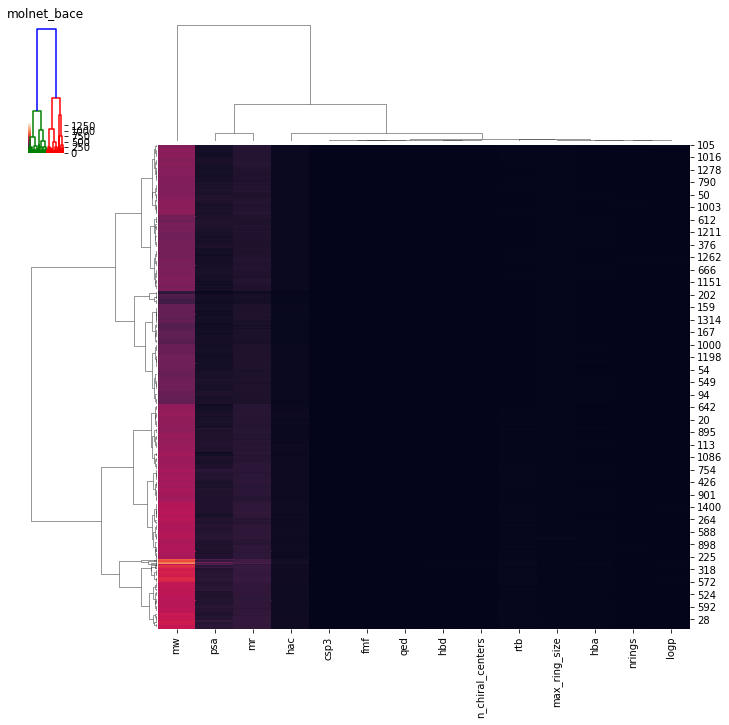

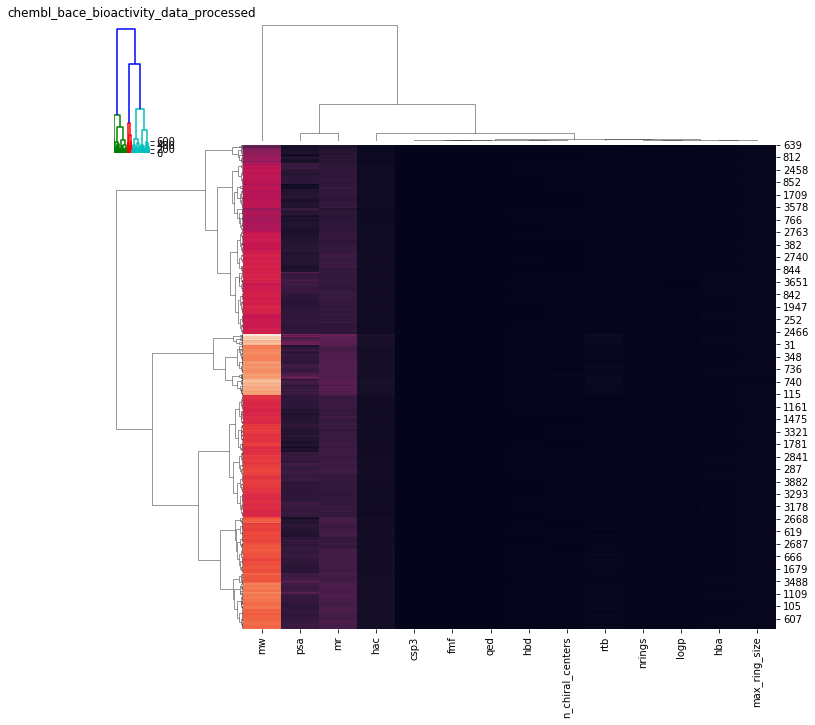

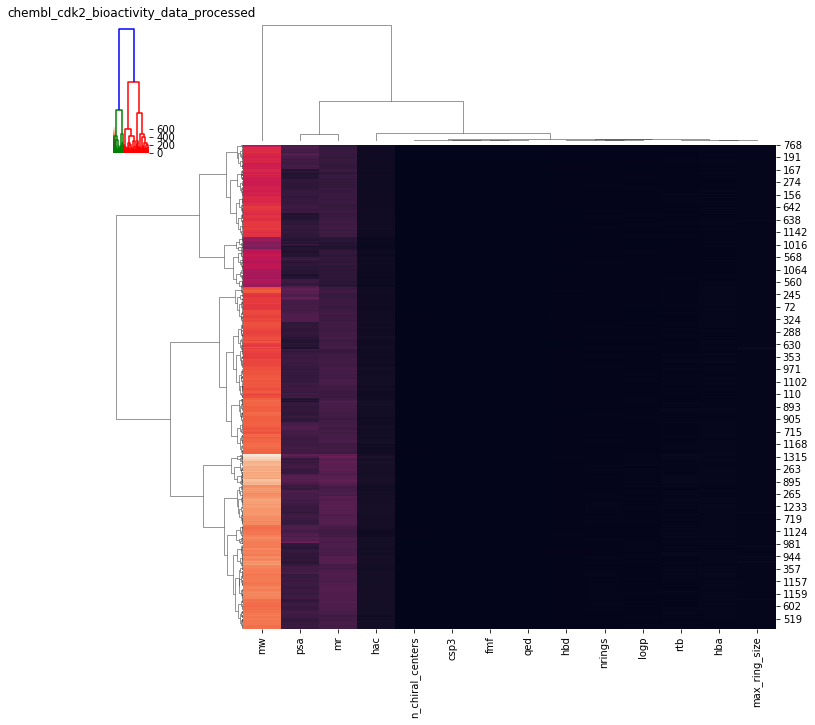

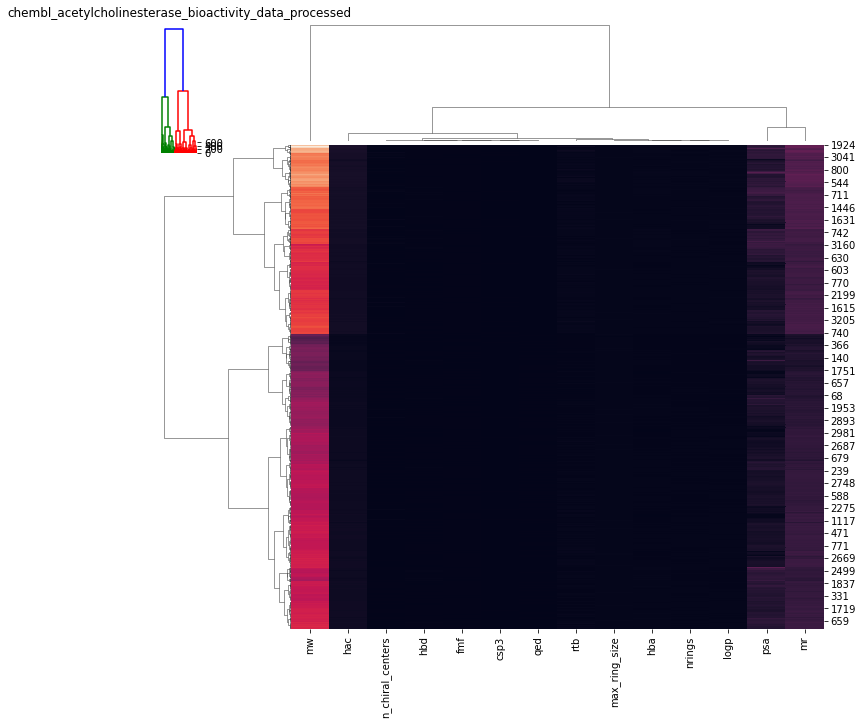

In [ ]:
import pandas as pd
import seaborn as sns  #用于画热图的工具包
from scipy.cluster import hierarchy  #用于进行层次聚类，话层次聚类图的工具包
from scipy import cluster   
import matplotlib.pyplot as plt
from sklearn import decomposition as skldec #用于主成分分析降维的包

files = ['molnet_bace.csv', 'chembl_bace_bioactivity_data_processed.csv', 'chembl_cdk2_bioactivity_data_processed.csv', 'chembl_acetylcholinesterase_bioactivity_data_processed.csv']
for fin in files:
  df = pd.read_csv(fin)
  if fin == 'molnet_bace.csv':		
    smiles = df["mol"].tolist()
  else:
    smiles = df["canonical_smiles"].tolist()
  physiochem_prop = PhysiochemPropCal(smiles)
  physiochem_prop_df = physiochem_prop.compute_physiochem()
  sns.clustermap(physiochem_prop_df.astype(float),method ='ward',metric='euclidean')
    #层次聚类树状图    
  Z = hierarchy.linkage(physiochem_prop_df, method ='ward',metric='euclidean')
  hierarchy.dendrogram(Z, labels = physiochem_prop_df.index)
  #在某个高度进行剪切
  label = cluster.hierarchy.cut_tree(Z,height=0.8)
  label = label.reshape(label.size)
  plt.title(fin.replace('.csv', ''))


molnet_bace.csv


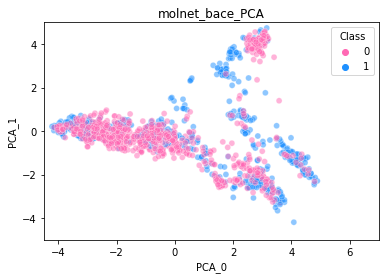

chembl_bace_bioactivity_data_processed.csv


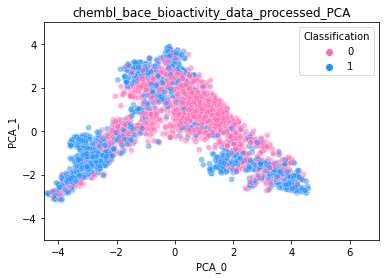

chembl_cdk2_bioactivity_data_processed.csv


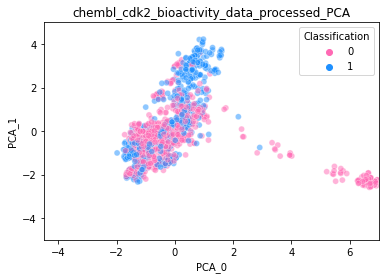

chembl_acetylcholinesterase_bioactivity_data_processed.csv


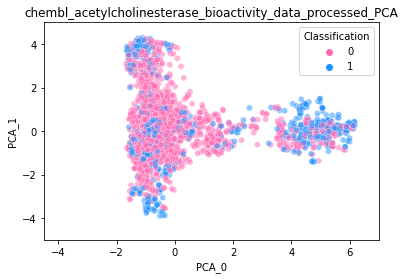

In [9]:

from sklearn.decomposition import PCA
import seaborn as sns

# Silence non-critical RDKit warnings to minimize unnecessary outputs
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)
  

files = ['molnet_bace.csv', 'chembl_bace_bioactivity_data_processed.csv', 'chembl_cdk2_bioactivity_data_processed.csv', 'chembl_acetylcholinesterase_bioactivity_data_processed.csv']
for fin in files:
  print(fin)
  df = pd.read_csv(fin)
  if fin == 'molnet_bace.csv':		
    smiles = df["mol"].tolist()
  else:
    smiles = df["canonical_smiles"].tolist()
  ecfp6_prop = ECFP6(smiles)
  ecfp6_prop_df = ecfp6_prop.compute_ECFP6()
  # PCA
  pca = PCA(n_components=2)
  X_pca = pca.fit_transform(ecfp6_prop_df)
  df["PCA_0"], df["PCA_1"] = X_pca[:,0], X_pca[:,1]

  file_name = fin.replace('.csv', '')
  #fig, axes = plt.subplots(1, 1, figsize=(15, 15))
  palette = sns.color_palette(["hotpink", "dodgerblue"])
  if fin == 'molnet_bace.csv':		
    ax = sns.scatterplot(data=df,x=df["PCA_0"], y=df["PCA_1"],hue="Class",alpha=0.5,palette=palette)
  else:
    ax = sns.scatterplot(data=df,x=df["PCA_0"], y=df["PCA_1"],hue="Classification",alpha=0.5,palette=palette)
  ax.set_xlim(-4.5,7)
  ax.set_ylim(-5,5)
  ax.set_title(file_name + '_PCA')
  plt.show()

